# Logit Differences

## load libraries

In [2]:
import transformer_lens
import torch
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import helpers, model_loaders, data_loaders

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model = model_loaders.load_model(model_type="gpt2-xl", DEVICE="cpu")

Loaded pretrained model gpt2-xl into HookedTransformer


## Metrics

In [4]:
def plot_scores(top_logits, top_indc, tokens=None, logits=None):

    fontsize = 12
    fig, ax = plt.subplots(1, 1, figsize=(14, 2), gridspec_kw={'hspace': 0.4})

    x = np.arange(0,top_logits.shape[-1])
    top1, = ax.plot(x, top_logits[...,0,:].detach().squeeze().numpy(), label=f"top1 {model.to_string(top_indc[...,0,:])}")
    top2, = ax.plot(x, top_logits[...,1,:].detach().squeeze().numpy(), label=f"top2 {model.to_string(top_indc[...,1,:])}")

    #fig.suptitle('first2sec logits', fontsize=fontsize)
    if tokens is not None:
        tok_labels = []
        tok_list = tokens.squeeze().tolist()[1:]
        for i, tok in enumerate(tok_list):
            tok_labels.append(model.tokenizer.convert_ids_to_tokens(tok))
        ax.set_xticks(x.tolist(), labels=tok_labels)

    if logits is not None:
        prefix_logits = logits[..., torch.arange(tokens.shape[-1]-1), tokens[0,1:]]
        print(prefix_logits.shape, x, tokens.shape)
        prompt_logs, = ax.plot(x, prefix_logits.detach().squeeze().numpy(), label=f"prompt", c="gray", linestyle=":")

    ax.set_xlabel('token pos', fontsize=fontsize)
    ax.set_ylabel('log probs', fontsize=fontsize)
    ax.legend(handles=[top1, top2], loc='upper left')
    #ax.savefig("...", dpi=200, bbox_inches='tight')


In [5]:
def plot_scores(prefix_score, prefix_str=None, topK_scores=None, topK_toks=None):

    fontsize = 12
    fig, ax = plt.subplots(1, 1, figsize=(14, 3), gridspec_kw={'hspace': 0.4})
    legend_lines = []
    
    x = np.arange(0, prefix_score.shape[-1])
    prompt_logs, = ax.plot(x, prefix_score.detach().squeeze().numpy(), label=f"prefix", c="gray", linestyle=":")
    legend_lines.append(prompt_logs)
    
    if prefix_str is not None:
        prefix_str_list = model.to_str_tokens(prefix_str)[1:]
        ax.set_xticks(x.tolist(), labels=prefix_str_list)

    if topK_scores is not None and topK_toks is not None:
        cmap = plt.cm.viridis
        norm = mpl.colors.Normalize(0,topK_scores.shape[-1])
        colors = cmap(norm(range(topK_scores.shape[-1])))
        for seq_idx in range(topK_scores.shape[-1]):
            topK_line, = ax.plot(x, topK_scores[...,:-1,seq_idx].detach().squeeze().numpy(), c=colors[seq_idx], label=f"top{seq_idx+1}")
            legend_lines.append(topK_line)
            topK_string = model.to_str_tokens(topK_toks[...,:,seq_idx])
    
            for tick_idx, tick in enumerate(ax.get_xticklabels()):
                tick_pos = tick.get_position()
                x_pos = -0.3 + tick_pos[0]
                y_pos = -0.25 - (seq_idx/10)
                ax.text(x_pos,y_pos,s=topK_string[tick_idx], c=colors[seq_idx]) # transform=ax.transAxes
        
    #ax.set_xlabel('token pos', fontsize=fontsize)
    ax.set_ylabel('score', fontsize=fontsize)
    ax.legend(handles=legend_lines, loc='upper left')
    #ax.savefig("...", dpi=200, bbox_inches='tight')

torch.Size([1, 9, 2]) 9


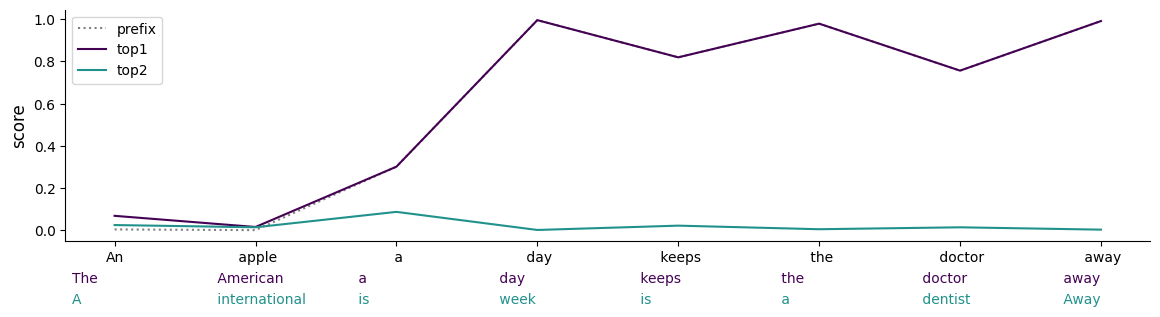

In [6]:
prefix = "An apple a day keeps the doctor away"
#prefix = "In the town where I was born. Lived a man who sailed to sea. And he told us of his life. In the land of submarines"
#prefix = "So we sailed on to the sun. Till we found the sea of green. And we lived beneath the waves. In our yellow submarine"

#prefix = "Our Father in heaven, hallowed be your name, your kingdom come, your will be done, on earth as in heaven."

toks_I = model.to_tokens(prefix)
logits_NIT = model(toks_I)
scores_NIT = (torch.nn.functional.softmax(logits_NIT, dim=-1))

scores_I = helpers.gather_token_scores(scores_NIT, toks_I, pool=[])
top_scores_Ik, top_idcs_Ik = helpers.get_topK(scores_NIT, topK=2, minK=False)
print(top_scores_Ik.shape, len(model.to_str_tokens(prefix)))

plot_scores(scores_I, prefix, top_scores_Ik, top_idcs_Ik)

#top_logits, top_indc = torch.topk(logits[...,:-1,:], 20, dim=-1)
#top_logits, top_indc = torch.transpose(top_logits,-2, -1), torch.transpose(top_indc,-2, -1)
#print(model.to_string(top_indc[...,:,0]), top_logits[...,:,0].sum().item())
#print(model.to_string(top_indc[...,:,1]), top_logits[...,:,1].sum().item())
#plot_scores(top_logits, top_indc, tokens, logits)

In [7]:
prefix = "Our Father in heaven, hallowed be your name, your kingdom come, your will be done, on earth as in heaven."
prefix = "Lead us not into temptation but deliver us from evil. For the kingdom, the power, and the glory are yours now and forever. Amen."

prefix = "Twinkle, twinkle, little star, How I wonder what you are! Up above the world so high, Like a diamond in the sky."
prefix = "When the blazing sun is gone, When he nothing shines upon, Then you show your little light, Twinkle, twinkle, all the night."

toks_I = model.to_tokens(prefix)
logits_NIT = model(toks_I)
scores_NIT = (torch.nn.functional.softmax(logits_NIT, dim=-1))

top_scores_Ik, top_idcs_Ik = helpers.get_topK(scores_NIT, topK=20, minK=False)
scores_I = helpers.gather_token_scores(scores_NIT, toks_I, pool=[])
(top_scores_Ik[...,:-1,0] - scores_I).mean()

tensor(0.1268, grad_fn=<MeanBackward0>)

In [260]:
scores_I.mean()

tensor(0.1876, grad_fn=<MeanBackward0>)